In [1]:
from rateslib import *
import matplotlib.pyplot as plt
from scipy.stats import norm
from math import log
from numba import jit
import numpy as np 
import pandas as pd
import warnings
import json
import os

In [2]:
@jit(nopython=True)
def single_sided_mida(b, w, t):
    sum_w = w.cumsum()
    t = sum_w[-1] if t > sum_w[-1] else t
    n = len(np.where(t > sum_w)[0])
    if n == 0:
        return b[0]
    else:
        sum_bw = (b * w).cumsum()
        p = b[0] * sum_w[0]
        for j in range(1, n):
            p += b[j] * (sum_w[j] - sum_w[j - 1])
            p += (sum_bw[j - 1] - b[j] * sum_w[j - 1]) * (log(sum_w[j]) - log(sum_w[j - 1]))
        p += b[n] * (t - sum_w[n - 1])
        p += (sum_bw[n - 1] - b[n] * sum_w[n - 1]) * (log(t) - log(sum_w[n - 1]))
        return p / t

def mean_intrinsic_depth_average(b, w, a, v, t):
    p_mbida = single_sided_mida(b, w, t)
    p_maida = single_sided_mida(a, v, t)
    return (p_mbida + p_maida) / 2

In [3]:
with open("Data/order_books/all_order_books_0320.json") as f:
    books = json.load(f)

results = []
order_books_by_symbol = {}

z1_indices = set(range(16, 18))
z2_indices = set(range(0, 3)) | set(range(30, 41))
z3_indices = set(range(18, 30))
z4_indices = set(range(3, 16))  

z1 = 250
z2 = 500
z3 = 1000
z4 = 2000

z_by_index = {}
for i in z1_indices: z_by_index[i] = z1
for i in z2_indices: z_by_index[i] = z2
for i in z3_indices: z_by_index[i] = z3
for i in z4_indices: z_by_index[i] = z4

for i, book in enumerate(books):
    
    z = z_by_index.get(i)

    b = np.array(book["bid_prices"], dtype=float)
    w = np.array(book["bid_sizes"], dtype=float)
    a = np.array(book["ask_prices"], dtype=float)
    v = np.array(book["ask_sizes"], dtype=float)

    # Replace sentinel prices and zero sizes with NaN
    invalid_bids = (b > 1e9) | (w <= 0)
    invalid_asks = (a > 1e9) | (v <= 0)
    b[invalid_bids] = np.nan
    w[invalid_bids] = np.nan
    a[invalid_asks] = np.nan
    v[invalid_asks] = np.nan

    # Filter valid entries
    valid_bids = ~np.isnan(b) & ~np.isnan(w)
    valid_asks = ~np.isnan(a) & ~np.isnan(v)

    b_clean = b[valid_bids]
    w_clean = w[valid_bids]
    a_clean = a[valid_asks]
    v_clean = v[valid_asks]

    if len(b_clean) > 0 and len(a_clean) > 0:
        mid_price = mean_intrinsic_depth_average(b_clean, w_clean, a_clean, v_clean, z)
    else:
        mid_price = None

    results.append({
        "Instrument": book["symbol"],
        "Mid-Price": mid_price
    })

    order_books_by_symbol[book["symbol"]] = pd.DataFrame({
        "Bid Size": w,
        "Bid Price": b,
        "Ask Price": a,
        "Ask Size": v
    })

results_df = pd.DataFrame(results)

In [4]:
order_books_by_symbol["SR3M5"]

,Bid Size,Bid Price,Ask Price,Ask Size
0,1035.0,95.905,95.910,774.0
1,1433.0,95.900,95.915,1080.0
2,1341.0,95.895,95.920,1226.0
3,1286.0,95.890,95.925,1144.0
4,1218.0,95.885,95.930,1195.0
5,1218.0,95.880,95.935,1053.0
6,1170.0,95.875,95.940,1391.0
7,1275.0,95.870,95.945,1274.0
8,1233.0,95.865,95.950,1473.0
9,1161.0,95.860,95.955,1335.0


In [5]:
results_df

,Instrument,Mid-Price
0,SR1H5,95.676250
1,SR1J5,95.687500
2,SR1K5,95.732500
3,SR3H5,95.688750
4,SR3M5,95.907767
5,SR3U5,96.147876
6,SR3Z5,96.317979
7,SR3H6,96.433299
8,SR3M6,96.495449
9,SR3U6,96.517383


In [6]:
def calculate_core_prices(A, s, w=None):
    
    if w is not None:
        W = np.diag(w)
        p_star = np.linalg.inv(A.T @ W @ A) @ (A.T @ W @ s)
    else:
        p_star = np.linalg.pinv(A) @ s
    return p_star

A = np.array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
              [1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 1, -1, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 1, -1, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 1, -1, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -1, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -1, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -1, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -1, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -1, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -1],
              [0, 0, 0, 1, -2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 1, -2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 1, -2, 1, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 1, -2, 1, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 1, -2, 1, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 1, -2, 1, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -2, 1, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -2, 1, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -2, 1, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -2, 1, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -2, 1]])
s = []

for _, row in results_df.iterrows():
    price = row["Mid-Price"]
    if isinstance(price, float):
        if "-" in row["Instrument"]:
            price = price * 0.01  # If instrument is a spread, convert from ticks to price
        s.append(price)

s = np.array(s)

assert np.linalg.matrix_rank(A) == A.shape[1] #Check for full column rank

core_prices = calculate_core_prices(A, s, w = [1.0] * 16 + [0.2] * 2 + [0.5] * 12 + [0.2] * 11)

print("Core Implied Prices:", core_prices)

Core Implied Prices: [95.67512601 95.68870998 95.73241401 95.68888302 95.90742117 96.14751787
 96.31907878 96.4328463  96.49561536 96.51768043 96.51174194 96.48933746
 96.45826944 96.4263706  96.39491942 96.36213321]


In [7]:
core_rates = 100 - core_prices
print("Core Implied Rates:", core_rates)

Core Implied Rates: [4.32487399 4.31129002 4.26758599 4.31111698 4.09257883 3.85248213
 3.68092122 3.5671537  3.50438464 3.48231957 3.48825806 3.51066254
 3.54173056 3.5736294  3.60508058 3.63786679]


In [8]:
core_rates_df = pd.DataFrame({
    "Rate": np.round(core_rates, 5)
})
print(core_rates_df)

       Rate
0   4.32487
1   4.31129
2   4.26759
3   4.31112
4   4.09258
5   3.85248
6   3.68092
7   3.56715
8   3.50438
9   3.48232
10  3.48826
11  3.51066
12  3.54173
13  3.57363
14  3.60508
15  3.63787


In [9]:
curve_sofr = Curve(
    nodes={
        dt(2025, 3, 20): 1.0,
        dt(2025, 4, 1): 1.0,
        dt(2025, 5, 1): 1.0,
        dt(2025, 6, 1): 1.0,
        dt(2025, 6, 18): 1.0,
        dt(2025, 9, 17): 1.0,
        dt(2025, 12, 17): 1.0,
        dt(2026, 3, 18): 1.0,
        dt(2026, 6, 17): 1.0,
        dt(2026, 9, 16): 1.0,
        dt(2026, 12, 16): 1.0,
        dt(2027, 3, 17): 1.0,
        dt(2027, 6, 16): 1.0,
        dt(2027, 9, 15): 1.0,
        dt(2027, 12, 15): 1.0,
        dt(2028, 3, 15): 1.0,
        dt(2028, 6, 21): 1.0,
    },
    interpolation="log_linear",
    calendar="nyc",
    convention="act360",
    modifier="MF",
    id="sofr",
)

In [10]:
sofr_2003 = pd.DataFrame(
    data=[4.33, 4.33, 4.34, 4.35, 4.34, 4.33, 4.32, 4.31, 4.3, 4.3, 4.32, 4.31, 4.29],
    index=pd.Index(["03-03-2025", "04-03-2025", "05-03-2025", "06-03-2025", "07-03-2025", "10-03-2025", "11-03-2025", "12-03-2025", "13-03-2025",
                    "14-03-2025", "17-03-2025", "18-03-2025", "19-03-2025"], name="reference_date"),
    columns=["rate"]
)

In [11]:
sofr_2003.to_csv("sofr_2003.csv")

In [12]:
defaults.fixings.directory = os.getcwd()

In [13]:
defaults.fixings["sofr_2003"]

reference_date
2025-03-03    4.33
2025-03-04    4.33
2025-03-05    4.34
2025-03-06    4.35
2025-03-07    4.34
2025-03-10    4.33
2025-03-11    4.32
2025-03-12    4.31
2025-03-13    4.30
2025-03-14    4.30
2025-03-17    4.32
2025-03-18    4.31
2025-03-19    4.29
Name: rate, dtype: float64

In [14]:
args_1m = dict(spec="usd_stir1", curves="sofr")
args_3m = dict(spec="usd_stir", curves="sofr")
sofr_futures = [
    STIRFuture(dt(2025, 3, 1), dt(2025, 4, 1), leg2_fixings=defaults.fixings["sofr_2003"], **args_1m),
    STIRFuture(dt(2025, 4, 1), dt(2025, 5, 1), **args_1m),
    STIRFuture(dt(2025, 5, 1), dt(2025, 6, 1), **args_1m),
    STIRFuture(effective=get_imm(code="H25"), termination="3m", leg2_fixings=defaults.fixings["sofr_2003"], **args_3m),
    STIRFuture(effective=get_imm(code="M25"), termination="3m", **args_3m),
    STIRFuture(effective=get_imm(code="U25"), termination="3m", **args_3m),
    STIRFuture(effective=get_imm(code="Z25"), termination="3m", **args_3m),
    STIRFuture(effective=get_imm(code="H26"), termination="3m", **args_3m),
    STIRFuture(effective=get_imm(code="M26"), termination="3m", **args_3m),
    STIRFuture(effective=get_imm(code="U26"), termination="3m", **args_3m),
    STIRFuture(effective=get_imm(code="Z26"), termination="3m", **args_3m),
    STIRFuture(effective=get_imm(code="H27"), termination="3m", **args_3m),
    STIRFuture(effective=get_imm(code="M27"), termination="3m", **args_3m),
    STIRFuture(effective=get_imm(code="U27"), termination="3m", **args_3m),
    STIRFuture(effective=get_imm(code="Z27"), termination="3m", **args_3m),
    STIRFuture(effective=get_imm(code="H28"), termination="3m", **args_3m),
]

In [15]:
s_sofr =  core_rates_df["Rate"].tolist()

In [16]:
instrument_labels_sofr = ["1H5", "1J5", "1K5", "H5", "M5", "U5", "Z5", "H6", "M6", "U6", "Z6", "H7", "M7", "U7", "Z7", "H8"]

In [17]:
solver_sofr = Solver(
    curves=[curve_sofr],
    instruments=sofr_futures,
    s=s_sofr,
    instrument_labels=instrument_labels_sofr,
    id="sofr",
)

SUCCESS: `func_tol` reached after 4 iterations (levenberg_marquardt), `f_val`: 2.2075646840876718e-14, `time`: 0.2728s


In [18]:
for inst in sofr_futures:
    print(inst.rate(solver=solver_sofr).real)

4.324870000019798
4.311290000022527
4.267590000022164
4.311119941874794
4.092579942777528
3.8524799445463898
3.6809199471352114
3.5671499504712902
3.50437995447577
3.4823199590642884
3.4882599641477845
3.5106599696361513
3.5417299754379803
3.5736299814627346
3.6050799876214596
3.637869993357047


In [19]:
curve_irs = Curve(
     nodes={
        dt(2025, 3, 20): 1.00,  # today's DF
        dt(2025, 3, 31): 1.00, #turn 1
        dt(2025, 4, 1): 1.00, #turn 1
        dt(2025, 5, 8): 1.00,  # defined effective FOMC dates..
        dt(2025, 6, 20): 1.00,
        dt(2025, 6, 30): 1.00, #turn 2
        dt(2025, 7, 1): 1.00, #turn 2
        dt(2025, 7, 31): 1.00,
        dt(2025, 9, 18): 1.00,
        dt(2025, 9, 30): 1.00, #turn 3
        dt(2025, 10, 1): 1.00, #turn 3
        dt(2025, 10, 30): 1.00,
        dt(2025, 12, 11): 1.00,
        dt(2025, 12, 31): 1.00, #turn 4
        dt(2026, 1, 2): 1.00, #turn 4
        dt(2026, 1, 29): 1.00,
        dt(2026, 3, 19): 1.00,
        dt(2026, 3, 31): 1.00, #turn 5
        dt(2026, 4, 1): 1.00, #turn 5
        dt(2026, 4, 30): 1.00,  
        dt(2026, 6, 18): 1.00,
        dt(2026, 6, 30): 1.00, #turn 6
        dt(2026, 7, 1): 1.00, #turn 6
        dt(2026, 7, 30): 1.00,
        dt(2026, 9, 17): 1.00,
        dt(2026, 9, 30): 1.00, #turn 7
        dt(2026, 10, 1): 1.00, #turn 7
        dt(2026, 10, 29): 1.00,
        dt(2026, 12, 10): 1.00,
        dt(2026, 12, 31): 1.00, #turn 8
        dt(2027, 1, 4): 1.00, #turn 8
        dt(2027, 1, 28): 1.00,
        dt(2027, 3, 18): 1.00, # estimated effective FOMC dates...
        dt(2027, 3, 31): 1.00, #turn 9
        dt(2027, 4, 1): 1.00, #turn 9
        dt(2027, 5, 6): 1.00,  
        dt(2027, 6, 17): 1.00,
        dt(2027, 6, 30): 1.00, #turn 10
        dt(2027, 7, 1): 1.00, #turn 10
        dt(2027, 7, 29): 1.00,
        dt(2027, 9, 16): 1.00,
        dt(2027, 9, 30): 1.00, #turn 11
        dt(2027, 10, 1): 1.00, #turn 11
        dt(2027, 11, 5): 1.00,
        dt(2027, 12, 16): 1.00,
        dt(2027, 12, 31): 1.00, #turn 12
        dt(2028, 1, 3): 1.00, #turn 12
        dt(2028, 1, 27): 1.00,
        dt(2028, 3, 9): 1.00,
        dt(2028, 3, 31): 1.00, #turn 13
        dt(2028, 4, 3): 1.00, #turn 13
        dt(2028, 4, 20): 1.00,
        dt(2028, 6, 21): 1.00,  # final IMM.
    },
    interpolation="log_linear",
    calendar="nyc",
    convention="act360",
    modifier="MF",
    id="irs",
)

In [20]:
args_const = dict(termination="1d", frequency="A", curves="irs")
args_fomc = dict(spec="usd_irs", curves="irs")
fomc_1 = IRS(dt(2025, 5, 8), dt(2025, 6, 20), **args_fomc)
fomc_2 = IRS(dt(2025, 6, 20), dt(2025, 7, 31), **args_fomc)
fomc_3 = IRS(dt(2025, 7, 31), dt(2025, 9, 18), **args_fomc)
fomc_4 = IRS(dt(2025, 9, 18), dt(2025, 10, 30), **args_fomc)
fomc_5 = IRS(dt(2025, 10, 30), dt(2025, 12, 11), **args_fomc)
fomc_6 = IRS(dt(2025, 12, 11), dt(2026, 1, 29), **args_fomc)
fomc_7 = IRS(dt(2026, 1, 29), dt(2026, 3, 19), **args_fomc)
fomc_8 = IRS(dt(2026, 3, 19), dt(2026, 4, 30), **args_fomc)
fomc_9 = IRS(dt(2026, 4, 30), dt(2026, 6, 18), **args_fomc)
fomc_10 = IRS(dt(2026, 6, 18), dt(2026, 7, 30), **args_fomc)
fomc_11 = IRS(dt(2026, 7, 30), dt(2026, 9, 17), **args_fomc)
fomc_12 = IRS(dt(2026, 9, 17), dt(2026, 10, 29), **args_fomc)
fomc_13 = IRS(dt(2026, 10, 29), dt(2026, 12, 10), **args_fomc)
fomc_14 = IRS(dt(2026, 12, 10), dt(2027, 1, 28), **args_fomc)
fomc_15 = IRS(dt(2027, 1, 28), dt(2027, 3, 18), **args_fomc)
fomc_16 = IRS(dt(2027, 3, 18), dt(2027, 5, 6), **args_fomc)
fomc_17 = IRS(dt(2027, 5, 6), dt(2027, 6, 17), **args_fomc)
fomc_18 = IRS(dt(2027, 6, 17), dt(2027, 7, 29), **args_fomc)
fomc_19 = IRS(dt(2027, 7, 29), dt(2027, 9, 16), **args_fomc)
fomc_20 = IRS(dt(2027, 9, 16), dt(2027, 11, 5), **args_fomc)
fomc_21 = IRS(dt(2027, 11, 5), dt(2027, 12, 16), **args_fomc)
fomc_22 = IRS(dt(2027, 12, 16), dt(2028, 1, 27), **args_fomc)
fomc_23 = IRS(dt(2028, 1, 27), dt(2028, 3, 9), **args_fomc)
fomc_24 = IRS(dt(2028, 3, 9), dt(2028, 4, 20), **args_fomc)
fomc_25 = IRS(dt(2028, 4, 20), dt(2028, 6, 21), **args_fomc)
turn_1a = IRS(effective=dt(2025, 3, 30), **args_const)
turn_1b = IRS(effective=dt(2025, 3, 31), **args_const)
turn_1c = IRS(effective=dt(2025, 4, 1), **args_const)
turn_2a = IRS(effective=dt(2025, 6, 29), **args_const)
turn_2b = IRS(effective=dt(2025, 6, 30), **args_const)
turn_2c = IRS(effective=dt(2025, 7, 1), **args_const)
turn_3a = IRS(effective=dt(2025, 9, 29), **args_const)
turn_3b = IRS(effective=dt(2025, 9, 30), **args_const)
turn_3c = IRS(effective=dt(2025, 10, 1), **args_const)
turn_4a = IRS(effective=dt(2025, 12, 30), **args_const)
turn_4b = IRS(effective=dt(2025, 12, 31), **args_const)
turn_4c = IRS(effective=dt(2026, 1, 2), **args_const)
turn_5a = IRS(effective=dt(2026, 3, 30), **args_const)
turn_5b = IRS(effective=dt(2026, 3, 31), **args_const)
turn_5c = IRS(effective=dt(2026, 4, 1), **args_const)
turn_6a = IRS(effective=dt(2026, 6, 29), **args_const)
turn_6b = IRS(effective=dt(2026, 6, 30), **args_const)
turn_6c = IRS(effective=dt(2026, 7, 1), **args_const)
turn_7a = IRS(effective=dt(2026, 9, 29), **args_const)
turn_7b = IRS(effective=dt(2026, 9, 30), **args_const)
turn_7c = IRS(effective=dt(2026, 10, 1), **args_const)
turn_8a = IRS(effective=dt(2026, 12, 30), **args_const)
turn_8b = IRS(effective=dt(2026, 12, 31), **args_const)
turn_8c = IRS(effective=dt(2027, 1, 4), **args_const)
turn_9a = IRS(effective=dt(2027, 3, 30), **args_const)
turn_9b = IRS(effective=dt(2027, 3, 31), **args_const)
turn_9c = IRS(effective=dt(2027, 4, 1), **args_const)
turn_10a = IRS(effective=dt(2027, 6, 29), **args_const)
turn_10b = IRS(effective=dt(2027, 6, 30), **args_const)
turn_10c = IRS(effective=dt(2027, 7, 1), **args_const)
turn_11a = IRS(effective=dt(2027, 9, 29), **args_const)
turn_11b = IRS(effective=dt(2027, 9, 30), **args_const)
turn_11c = IRS(effective=dt(2027, 10, 1), **args_const)
turn_12a = IRS(effective=dt(2027, 12, 30), **args_const)
turn_12b = IRS(effective=dt(2027, 12, 31), **args_const)
turn_12c = IRS(effective=dt(2028, 1, 3), **args_const)
turn_13a = IRS(effective=dt(2028, 3, 30), **args_const)
turn_13b = IRS(effective=dt(2028, 3, 31), **args_const)
turn_13c = IRS(effective=dt(2028, 4, 3), **args_const)

In [21]:
args_irs_adj = dict(spec="usd_irs", curves="sofr")
instruments_irs_adj = [
    IRS(dt(2025, 3, 1), dt(2025, 4, 1), leg2_fixings=defaults.fixings["sofr_2003"], **args_irs_adj),
    IRS(dt(2025, 4, 1), dt(2025, 5, 1), **args_irs_adj),
    IRS(dt(2025, 5, 1), dt(2025, 6, 1), **args_irs_adj),
    IRS(effective=get_imm(code="H25"), termination="3m", roll="imm", leg2_fixings=defaults.fixings["sofr_2003"], **args_irs_adj),
    IRS(effective=get_imm(code="M25"), termination="3m", roll="imm", **args_irs_adj),
    IRS(effective=get_imm(code="U25"), termination="3m", roll="imm", **args_irs_adj),
    IRS(effective=get_imm(code="Z25"), termination="3m", roll="imm", **args_irs_adj),
    IRS(effective=get_imm(code="H26"), termination="3m", roll="imm", **args_irs_adj),
    IRS(effective=get_imm(code="M26"), termination="3m", roll="imm", **args_irs_adj),
    IRS(effective=get_imm(code="U26"), termination="3m", roll="imm", **args_irs_adj),
    IRS(effective=get_imm(code="Z26"), termination="3m", roll="imm", **args_irs_adj),
    IRS(effective=get_imm(code="H27"), termination="3m", roll="imm", **args_irs_adj),
    IRS(effective=get_imm(code="M27"), termination="3m", roll="imm", **args_irs_adj),
    IRS(effective=get_imm(code="U27"), termination="3m", roll="imm", **args_irs_adj),
    IRS(effective=get_imm(code="Z27"), termination="3m", roll="imm", **args_irs_adj),
    IRS(effective=get_imm(code="H28"), termination="3m", roll="imm", **args_irs_adj),
]

In [22]:
convx_adj = [0, -0.00006, -0.00035, -0.00003, -0.0020, -0.00529, -0.00989, -0.01574, -0.02283, -0.03111, -0.04057, -0.05117, -0.06288, -0.07569, 
             -0.08956, -0.10558]
s_adj = [
 inst.rate(solver=solver_sofr).real + convx_adj for (inst,convx_adj) in zip(instruments_irs_adj[:16], convx_adj)
]
print(s_adj)

[4.331936089617567, 4.318465857186106, 4.274805172237337, 4.311089941874795, 4.090579942777528, 3.8471899445463897, 3.6710299471352115, 3.5514099504712897, 3.48154995447577, 3.451209959064289, 3.4476899641477843, 3.459489969636152, 3.478849975437981, 3.4979399814627343, 3.515519987621459, 3.532289993357046]


In [23]:
args_irs = dict(spec="usd_irs", curves="irs")
instruments_irs = [
    IRS(dt(2025, 3, 1), dt(2025, 4, 1), leg2_fixings=defaults.fixings["sofr_2003"], **args_irs),
    IRS(dt(2025, 4, 1), dt(2025, 5, 1), **args_irs),
    IRS(dt(2025, 5, 1), dt(2025, 6, 1), **args_irs),
    IRS(effective=get_imm(code="H25"), termination="3m", roll="imm", leg2_fixings=defaults.fixings["sofr_2003"], **args_irs),
    IRS(effective=get_imm(code="M25"), termination="3m", roll="imm", **args_irs),
    IRS(effective=get_imm(code="U25"), termination="3m", roll="imm", **args_irs),
    IRS(effective=get_imm(code="Z25"), termination="3m", roll="imm", **args_irs),
    IRS(effective=get_imm(code="H26"), termination="3m", roll="imm", **args_irs),
    IRS(effective=get_imm(code="M26"), termination="3m", roll="imm", **args_irs),
    IRS(effective=get_imm(code="U26"), termination="3m", roll="imm", **args_irs),
    IRS(effective=get_imm(code="Z26"), termination="3m", roll="imm", **args_irs),
    IRS(effective=get_imm(code="H27"), termination="3m", roll="imm", **args_irs),
    IRS(effective=get_imm(code="M27"), termination="3m", roll="imm", **args_irs),
    IRS(effective=get_imm(code="U27"), termination="3m", roll="imm", **args_irs),
    IRS(effective=get_imm(code="Z27"), termination="3m", roll="imm", **args_irs),
    IRS(effective=get_imm(code="H28"), termination="3m", roll="imm", **args_irs),
    Spread(turn_1a, turn_1b),
    Spread(turn_1b, turn_1c),
    Spread(turn_2a, turn_2b),
    Spread(turn_2b, turn_2c), 
    Spread(turn_3a, turn_3b),
    Spread(turn_3b, turn_3c),
    Spread(turn_4a, turn_4b),
    Spread(turn_4b, turn_4c),
    Spread(turn_5a, turn_5b),
    Spread(turn_5b, turn_5c),
    Spread(turn_6a, turn_6b),
    Spread(turn_6b, turn_6c),
    Spread(turn_7a, turn_7b),
    Spread(turn_7b, turn_7c), 
    Spread(turn_8a, turn_8b), 
    Spread(turn_8b, turn_8c),
    Spread(turn_9a, turn_9b),
    Spread(turn_9b, turn_9c),
    Spread(turn_10a, turn_10b), 
    Spread(turn_10b, turn_10c), 
    Spread(turn_11a, turn_11b),
    Spread(turn_11b, turn_11c),
    Spread(turn_12a, turn_12b),
    Spread(turn_12b, turn_12c), 
    Spread(turn_13a, turn_13b), 
    Spread(turn_13b, turn_13c),
    Fly(fomc_1, fomc_2, fomc_3),
    Fly(fomc_3, fomc_4, fomc_5),
    Fly(fomc_5, fomc_6, fomc_7),
    Fly(fomc_7, fomc_8, fomc_9),
    Fly(fomc_9, fomc_10, fomc_11),
    Fly(fomc_11, fomc_12, fomc_13),
    Fly(fomc_13, fomc_14, fomc_15),
    Fly(fomc_15, fomc_16, fomc_17),
    Fly(fomc_17, fomc_18, fomc_19),
    Fly(fomc_19, fomc_20, fomc_21),
    Fly(fomc_21, fomc_22, fomc_23),
    Fly(fomc_23, fomc_24, fomc_25),
]

In [24]:
s_irs = s_adj + [5, -5] * 13 + [0] * 12

In [25]:
weights_irs = [1] * 16 + [1e-09] * 2 + [1] * 24 + [1e-09] * 12 #Includes low weighting for first turn to favor mkt instruments 

In [26]:
instrument_labels_irs = [
    "1H5", "1J5", "1K5", "H5", "M5", "U5", "Z5", "H6", "M6", "U6", "Z6", "H7", "M7", "U7", "Z7", "H8", "turn1_left", "turn1_right", 
    "turn2_left", "turn2_right", "turn3_left", "turn3_right", "turn4_left", "turn4_right", "turn5_left", "turn5_right", "turn6_left", 
    "turn6_right", "turn7_left", "turn7_right", "turn8_left", "turn8_right", "turn9_left", "turn9_right", "turn10_left", "turn10_right",
    "turn11_left", "turn11_right", "turn12_left", "turn12_right", "turn13_left", "turn13_right", "cv1", "cv2", "cv3", "cv4", "cv5", "cv6", 
    "cv7", "cv8", "cv9", "cv10", "cv11", "cv12",
]

In [27]:
solver_irs = Solver(
    pre_solvers=[solver_sofr],
    curves=[curve_irs],
    instruments=instruments_irs,
    s=s_irs,
    weights=weights_irs,
    instrument_labels=instrument_labels_irs,
    func_tol=1e-08,  
    conv_tol=1e-10,
    id="irs",
)

SUCCESS: `func_tol` reached after 12 iterations (levenberg_marquardt), `f_val`: 4.468851880603983e-09, `time`: 0.8893s


In [28]:
for inst in instruments_irs:
    print(inst.rate(solver=solver_irs).real)

4.331950516109568
4.318478814543525
4.274831639525468
4.311044369165824
4.090579941973787
3.8471899437437975
3.6710299463668923
3.551409949639086
3.4815499538534866
3.4512099582447
3.447689963393498
3.4594899693111127
3.4788499741665397
3.497939981845174
3.515519986185529
3.5322899929723532
4.225013444703052
-5.84543979860177
5.000000000432525
-5.000000000432436
4.999999999633076
-4.99999999963312
5.000000001231797
-4.9999999996331645
5.000000000432481
-5.000000001231841
5.000000002031069
-4.999999999632987
5.0000000012317525
-4.99999999803431
5.0000000012317525
-4.99999999803431
5.0000000004323475
-4.999999999633031
5.000000005228644
-4.999999990840154
5.000000027610607
-4.999999935684185
5.000000081967126
-4.999999876531458
5.000000117938397
-4.999999905308528
-1.3614991090094009e-05
6.258337847953044e-06
-4.9333883822555435e-05
0.00011247456810359324
-0.0002942192613097916
0.00030247445352848956
-0.00013218438579265523
-0.0006805319054503656
0.001462217190661974
-0.00279549151023239

In [29]:
with pd.option_context('display.max_rows', None):
    print(solver_irs.error)

sofr  1H5             1.979839e-09
      1J5             2.252776e-09
      1K5             2.216360e-09
      H5             -5.812521e-06
      M5             -5.722247e-06
      U5             -5.545361e-06
      Z5             -5.286479e-06
      H6             -4.952871e-06
      M6             -4.552423e-06
      U6             -4.093571e-06
      Z6             -3.585222e-06
      H7             -3.036385e-06
      M7             -2.456202e-06
      U7             -1.853727e-06
      Z7             -1.237854e-06
      H8             -6.642953e-07
irs   1H5             1.442649e-03
      1J5             1.295736e-03
      1K5             2.646729e-03
      H5             -4.557271e-03
      M5             -8.037411e-08
      U5             -8.025922e-08
      Z5             -7.683192e-08
      H6             -8.322036e-08
      M6             -6.222836e-08
      U6             -8.195888e-08
      Z6             -7.542864e-08
      H7             -3.250391e-08
      M7            

(<Figure size 640x480 with 1 Axes>,
 <Axes: >,
  <matplotlib.lines.Line2D at 0x1d6fddbf6d0>])

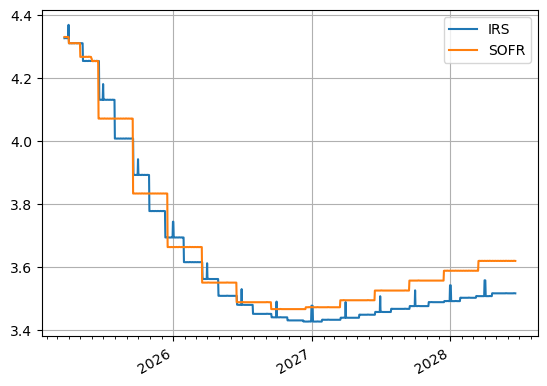

In [30]:
curve_irs.plot("1d", comparators=[curve_sofr], labels=["IRS", "SOFR"])

In [31]:
curve_full = Curve(
    nodes={
        dt(2025, 3, 20): 1.0,
        dt(2025, 6, 18): 1.00,
        dt(2025, 9, 17): 1.0,
        dt(2025, 12, 17): 1.0,
        dt(2026, 3, 18): 1.0,
        dt(2026, 6, 17): 1.0,
        dt(2026, 9, 16): 1.0,
        dt(2026, 12, 16): 1.0,
        dt(2027, 3, 17): 1.0,
        dt(2027, 6, 16): 1.0,
        dt(2027, 9, 15): 1.0,
        dt(2027, 12, 15): 1.0,
        dt(2028, 3, 15): 1.0,
        dt(2028, 6, 21): 1.0,
    },
    interpolation="log_linear",
    calendar="nyc",
    convention="act360",
    modifier="MF",
    id="irs",
)

In [32]:
instruments_full = [
    Spread(sofr_futures[3], IRS(effective=get_imm(code="H25"), termination="3m", roll="imm", leg2_fixings=defaults.fixings["sofr_2003"], **args_irs)),
    Spread(sofr_futures[4], IRS(effective=get_imm(code="M25"), termination="3m", roll="imm", **args_irs)),
    Spread(sofr_futures[5], IRS(effective=get_imm(code="U25"), termination="3m", roll="imm", **args_irs)),
    Spread(sofr_futures[6], IRS(effective=get_imm(code="Z25"), termination="3m", roll="imm", **args_irs)),
    Spread(sofr_futures[7], IRS(effective=get_imm(code="H26"), termination="3m", roll="imm", **args_irs)),
    Spread(sofr_futures[8], IRS(effective=get_imm(code="M26"), termination="3m", roll="imm", **args_irs)),
    Spread(sofr_futures[9], IRS(effective=get_imm(code="U26"), termination="3m", roll="imm", **args_irs)),
    Spread(sofr_futures[10], IRS(effective=get_imm(code="Z26"), termination="3m", roll="imm", **args_irs)),
    Spread(sofr_futures[11], IRS(effective=get_imm(code="H27"), termination="3m", roll="imm", **args_irs)),
    Spread(sofr_futures[12], IRS(effective=get_imm(code="M27"), termination="3m", roll="imm", **args_irs)),
    Spread(sofr_futures[13], IRS(effective=get_imm(code="U27"), termination="3m", roll="imm", **args_irs)),
    Spread(sofr_futures[14], IRS(effective=get_imm(code="Z27"), termination="3m", roll="imm", **args_irs)),
    Spread(sofr_futures[15], IRS(effective=get_imm(code="H28"), termination="3m", roll="imm", **args_irs)),
]

In [33]:
s_full = [adj *100 for adj in convx_adj[3:]] 
print(s_full)

[-0.003, -0.2, -0.529, -0.989, -1.574, -2.283, -3.1109999999999998, -4.057, -5.117, -6.288, -7.568999999999999, -8.956, -10.558]


In [34]:
instrument_labels_full = [
    "IMM H5", "IMM M5", "IMM U5", "IMM Z5", "IMM H6", "IMM M6", "IMM U6", "IMM Z6", "IMM H7", "IMM M7", "IMM U7", "IMM Z7", "IMM H8",
]

In [35]:
solver_full = Solver(
    pre_solvers=[solver_sofr],
    curves=[curve_full],
    instruments=instruments_full,
    s=s_full,
    instrument_labels=instrument_labels_full,
    id="full",
)

SUCCESS: `func_tol` reached after 4 iterations (levenberg_marquardt), `f_val`: 2.032356362500581e-21, `time`: 0.2291s


(<Figure size 640x480 with 1 Axes>,
 <Axes: >,
  <matplotlib.lines.Line2D at 0x1d6fdfe4700>])

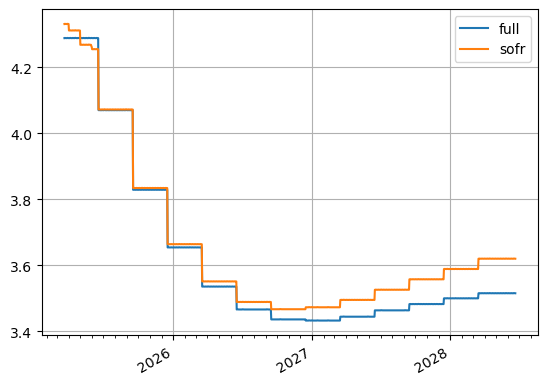

In [36]:
curve_full.plot("1d", comparators=[curve_sofr], labels=["full", "sofr"])

In [37]:
curve_fwd = Curve(
     nodes={
        dt(2025, 3, 20): 1.00,  
        dt(2025, 6, 18): 1.00,
        dt(2025, 9, 17): 1.00,
        dt(2025, 12, 17): 1.00,
        dt(2026, 3, 18): 1.00, 
        dt(2026, 6, 17): 1.00,
        dt(2026, 9, 16): 1.00,
        dt(2026, 12, 16): 1.00,
        dt(2027, 3, 17): 1.00,  
        dt(2027, 6, 16): 1.00,
        dt(2027, 9, 15): 1.00,
        dt(2027, 12, 15): 1.00,
        dt(2028, 3, 15): 1.00,
        dt(2028, 6, 21): 1.00,  
    },
    interpolation="log_linear",
    calendar="nyc",
    convention="act360",
    modifier="MF",
    id="irs",
)

In [38]:
instruments_fwd = instruments_irs[3:16]

In [39]:
s_fwd = [
 instrument.rate(solver=solver_irs).real for (instrument) in (instruments_fwd)
]

In [40]:
solver_fwd = Solver(
    pre_solvers=[solver_sofr],
    curves=[curve_fwd],
    instruments=instruments_fwd,
    s=s_fwd,
    instrument_labels=["IMM H5", "IMM M5", "IMM U5", "IMM Z5", "IMM H6", "IMM M6", "IMM U6", "IMM Z6", "IMM H7", "IMM M7", "IMM U7", "IMM Z7", "IMM H8"],
    id="fwd",
)

SUCCESS: `func_tol` reached after 4 iterations (levenberg_marquardt), `f_val`: 2.2237017513056477e-14, `time`: 0.1307s


In [41]:
for instrument in instruments_fwd:
    print(float(instrument.rate(solver=solver_fwd)))

4.311044310848341
4.090579884556683
3.847189888098639
3.671029893315615
3.551409899930805
3.481549908158523
3.4512099171493094
3.447689927395392
3.4594899388173506
3.4788499494939673
3.497939963219634
3.515519973744404
3.5322899862934496


In [42]:
curve_par = Curve(
      nodes={
        dt(2025, 3, 20): 1.00,  
        dt(2025, 6, 18): 1.00,
        dt(2025, 9, 17): 1.00,
        dt(2025, 12, 17): 1.00,
        dt(2026, 3, 18): 1.00, 
        dt(2026, 6, 17): 1.00,
        dt(2026, 9, 16): 1.00,
        dt(2026, 12, 16): 1.00,
        dt(2027, 3, 17): 1.00,  
        dt(2027, 6, 16): 1.00,
        dt(2027, 9, 15): 1.00,
        dt(2027, 12, 15): 1.00,
        dt(2028, 3, 15): 1.00,
        dt(2028, 6, 21): 1.00,
    },
    interpolation="log_linear",
    calendar="nyc",
    convention="act360",
    modifier="MF",
    id="irs",
)

In [43]:
instruments_par = [
    IRS(dt(2025, 3, 22), "3M", spec="usd_irs_lt_2y", curves="irs"), #+2 effective date  
    IRS(dt(2025, 3, 22), "6M", spec="usd_irs_lt_2y", curves="irs"),
    IRS(dt(2025, 3, 22), "9M", spec="usd_irs_lt_2y", curves="irs"),
    IRS(dt(2025, 3, 22), "1Y", spec="usd_irs_lt_2y", curves="irs"),
    IRS(dt(2025, 3, 22), "15M", spec="usd_irs_lt_2y", curves="irs"),
    IRS(dt(2025, 3, 22), "18M", spec="usd_irs_lt_2y", curves="irs"),
    IRS(dt(2025, 3, 22), "21M", spec="usd_irs_lt_2y", curves="irs"),
    IRS(dt(2025, 3, 22), "2Y", spec="usd_irs", curves="irs"),
    IRS(dt(2025, 3, 22), "27M", spec="usd_irs", curves="irs"),
    IRS(dt(2025, 3, 22), "30M", spec="usd_irs", curves="irs"),
    IRS(dt(2025, 3, 22), "33M", spec="usd_irs", curves="irs"),
    IRS(dt(2025, 3, 22), "3Y", spec="usd_irs", curves="irs"),
    IRS(dt(2025, 3, 22), "39M", spec="usd_irs", curves="irs"),
]

In [44]:
s_par = [
 instrument.rate(solver=solver_irs).real for (instrument) in (instruments_par)
]

In [45]:
solver_par = Solver(
    pre_solvers=[solver_sofr],
    curves=[curve_par],
    instruments=instruments_par,
    s=s_par,
    instrument_labels=["3M", "6M", "9M", "1Y", "15M", "18M", "21M", "2Y", "27M", "30M", "33M", "3Y", "39M"],
    id="par",
)

SUCCESS: `func_tol` reached after 4 iterations (levenberg_marquardt), `f_val`: 1.2166816569007033e-12, `time`: 0.0425s


In [46]:
for instrument in instruments_par:
    print(float(instrument.rate(solver=solver_irs)))

4.303324246252482
4.211774809095643
4.1133688619798585
4.0296812847411605
3.931471481750819
3.8620833086825326
3.8144043039096807
3.782895891557708
3.7463030824738115
3.7234989411625543
3.710107586945378
3.70314542235579
3.689439792993515


In [47]:
for instrument in instruments_par:
    print(float(instrument.rate(solver=solver_par)))

4.3033242387718715
4.211774810640562
4.11336886433727
4.02968129395669
3.9314714970892224
3.8620833125586245
3.8144043094648517
3.7828958995581656
3.7463030618645603
3.7234987889234645
3.71010728926564
3.703144771809385
3.6894389679102852


In [48]:
solver_fwd.jacobian(solver_par).style.format("{:,.2f}")

In [49]:
solver_par.jacobian(solver_fwd).style.format("{:,.2f}")

In [50]:
pd.DataFrame(solver_par.jacobian(solver_fwd) - np.linalg.inv(solver_fwd.jacobian(solver_par))).style.format("{:,.2f}")

In [51]:
pd.DataFrame(solver_fwd.jacobian(solver_par) - np.linalg.inv(solver_par.jacobian(solver_fwd))).style.format("{:,.2f}")

In [52]:
fwd_risk = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1000, 0, 0, 0])[:, np.newaxis]
par_risk = np.matmul(solver_fwd.jacobian(solver_par), fwd_risk)
par_risk.style.format("{:,.2f}")

In [53]:
fwd_risk_reversed = np.matmul(solver_par.jacobian(solver_fwd), par_risk)
fwd_risk_reversed.style.format("{:,.2f}")

In [54]:
matrix = np.array([
    [1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1,  0,  0,  0,  0,  0,  0,  0], 
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1,  1,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1, -1,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1, -1,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1, -1,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  1, -1],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1],
])

try:
    inverse_matrix = np.linalg.inv(matrix)
except np.linalg.LinAlgError:
    print("The matrix is singular and cannot be inverted.")

In [55]:
historical_prices = pd.read_csv("back_adjusted_sofr_rates0320.csv", index_col=0, parse_dates=True)

In [56]:
historical_prices

,SR1.c.0,SR1.c.1,SR1.c.2,1F,2F,3F,4F,5F,6F,7F,...,IMM4,IMM5,IMM6,IMM7,IMM8,IMM9,IMM10,IMM11,IMM12,IMM13
date,,,,,,,,,,,,,,,,,,,,,
2024-03-19,95.6300,95.5825,95.795,95.9125,96.075,96.075,96.110,96.180,96.250,96.280,...,96.110,96.180,96.250,96.280,96.280,96.285,96.280,96.280,96.275,96.275
2024-03-20,95.6300,95.5825,95.815,95.9225,96.130,96.165,96.215,96.285,96.350,96.365,...,96.215,96.285,96.350,96.365,96.350,96.345,96.335,96.330,96.315,96.310
2024-03-21,95.6300,95.5825,95.810,95.9175,96.110,96.150,96.190,96.255,96.315,96.335,...,96.190,96.255,96.315,96.335,96.335,96.335,96.325,96.320,96.310,96.305
2024-03-22,95.6300,95.5825,95.815,95.9225,96.130,96.170,96.215,96.285,96.355,96.385,...,96.215,96.285,96.355,96.385,96.390,96.395,96.390,96.385,96.370,96.360
2024-03-25,95.6275,95.5775,95.805,95.9175,96.110,96.140,96.180,96.250,96.320,96.350,...,96.180,96.250,96.320,96.350,96.350,96.355,96.350,96.345,96.335,96.325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-13,95.6725,95.6900,95.765,95.7075,95.960,96.210,96.360,96.450,96.490,96.495,...,96.360,96.450,96.490,96.495,96.480,96.455,96.425,96.395,96.365,96.330
2025-03-14,95.6750,95.6900,95.755,95.7000,95.930,96.145,96.280,96.365,96.405,96.415,...,96.280,96.365,96.405,96.415,96.410,96.390,96.365,96.340,96.310,96.275
2025-03-17,95.6750,95.6900,95.740,95.6875,95.885,96.095,96.235,96.325,96.375,96.390,...,96.235,96.325,96.375,96.390,96.385,96.370,96.350,96.325,96.300,96.265


In [57]:
historical_rates = 100 - historical_prices

In [58]:
historical_rates

,SR1.c.0,SR1.c.1,SR1.c.2,1F,2F,3F,4F,5F,6F,7F,...,IMM4,IMM5,IMM6,IMM7,IMM8,IMM9,IMM10,IMM11,IMM12,IMM13
date,,,,,,,,,,,,,,,,,,,,,
2024-03-19,4.3700,4.4175,4.205,4.0875,3.925,3.925,3.890,3.820,3.750,3.720,...,3.890,3.820,3.750,3.720,3.720,3.715,3.720,3.720,3.725,3.725
2024-03-20,4.3700,4.4175,4.185,4.0775,3.870,3.835,3.785,3.715,3.650,3.635,...,3.785,3.715,3.650,3.635,3.650,3.655,3.665,3.670,3.685,3.690
2024-03-21,4.3700,4.4175,4.190,4.0825,3.890,3.850,3.810,3.745,3.685,3.665,...,3.810,3.745,3.685,3.665,3.665,3.665,3.675,3.680,3.690,3.695
2024-03-22,4.3700,4.4175,4.185,4.0775,3.870,3.830,3.785,3.715,3.645,3.615,...,3.785,3.715,3.645,3.615,3.610,3.605,3.610,3.615,3.630,3.640
2024-03-25,4.3725,4.4225,4.195,4.0825,3.890,3.860,3.820,3.750,3.680,3.650,...,3.820,3.750,3.680,3.650,3.650,3.645,3.650,3.655,3.665,3.675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-13,4.3275,4.3100,4.235,4.2925,4.040,3.790,3.640,3.550,3.510,3.505,...,3.640,3.550,3.510,3.505,3.520,3.545,3.575,3.605,3.635,3.670
2025-03-14,4.3250,4.3100,4.245,4.3000,4.070,3.855,3.720,3.635,3.595,3.585,...,3.720,3.635,3.595,3.585,3.590,3.610,3.635,3.660,3.690,3.725
2025-03-17,4.3250,4.3100,4.260,4.3125,4.115,3.905,3.765,3.675,3.625,3.610,...,3.765,3.675,3.625,3.610,3.615,3.630,3.650,3.675,3.700,3.735


In [59]:
# Compute daily rate changes in basis points (today - yesterday)
historical_chgs = historical_rates.diff() * 100

historical_chgs.style.format("{:,.1f}")

,SR1.c.0,SR1.c.1,SR1.c.2,1F,2F,3F,4F,5F,6F,7F,8F,9F,10F,11F,12F,13F,IMM1,IMM2,IMM3,IMM4,IMM5,IMM6,IMM7,IMM8,IMM9,IMM10,IMM11,IMM12,IMM13
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-03-19 00:00:00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2024-03-20 00:00:00,0.0,0.0,-2.0,-1.0,-5.5,-9.0,-10.5,-10.5,-10.0,-8.5,-7.0,-6.0,-5.5,-5.0,-4.0,-3.5,-1.0,-5.5,-9.0,-10.5,-10.5,-10.0,-8.5,-7.0,-6.0,-5.5,-5.0,-4.0,-3.5
2024-03-21 00:00:00,0.0,0.0,0.5,0.5,2.0,1.5,2.5,3.0,3.5,3.0,1.5,1.0,1.0,1.0,0.5,0.5,0.5,2.0,1.5,2.5,3.0,3.5,3.0,1.5,1.0,1.0,1.0,0.5,0.5
2024-03-22 00:00:00,0.0,0.0,-0.5,-0.5,-2.0,-2.0,-2.5,-3.0,-4.0,-5.0,-5.5,-6.0,-6.5,-6.5,-6.0,-5.5,-0.5,-2.0,-2.0,-2.5,-3.0,-4.0,-5.0,-5.5,-6.0,-6.5,-6.5,-6.0,-5.5
2024-03-25 00:00:00,0.2,0.5,1.0,0.5,2.0,3.0,3.5,3.5,3.5,3.5,4.0,4.0,4.0,4.0,3.5,3.5,0.5,2.0,3.0,3.5,3.5,3.5,3.5,4.0,4.0,4.0,4.0,3.5,3.5
2024-03-26 00:00:00,0.0,-0.5,-0.5,-0.5,0.5,1.5,1.5,1.0,0.5,0.0,-1.0,-1.5,-2.0,-2.5,-2.5,-2.5,-0.5,0.5,1.5,1.5,1.0,0.5,0.0,-1.0,-1.5,-2.0,-2.5,-2.5,-2.5
2024-03-27 00:00:00,0.2,0.2,0.0,0.0,0.0,-1.0,-2.0,-2.5,-3.5,-4.0,-4.0,-4.5,-4.5,-4.5,-4.5,-4.5,0.0,0.0,-1.0,-2.0,-2.5,-3.5,-4.0,-4.0,-4.5,-4.5,-4.5,-4.5,-4.5
2024-03-28 00:00:00,-0.2,-0.2,0.5,0.2,2.0,4.5,5.5,6.0,6.0,5.5,4.5,3.5,2.0,1.0,0.0,-0.5,0.2,2.0,4.5,5.5,6.0,6.0,5.5,4.5,3.5,2.0,1.0,0.0,-0.5
2024-04-01 00:00:00,0.2,1.0,2.0,4.0,7.5,9.5,11.0,12.5,13.5,14.0,14.5,15.5,15.5,15.5,15.5,15.5,4.0,7.5,9.5,11.0,12.5,13.5,14.0,14.5,15.5,15.5,15.5,15.5,15.5


In [60]:
Q = historical_chgs.cov().to_numpy()
Q

array([[ 0.24071571,  0.49176508,  0.56367388,  0.61315452,  0.70407655,
         0.62421742,  0.48523762,  0.3598819 ,  0.25138731,  0.17426722,
         0.12254553,  0.09334092,  0.07907655,  0.07231787,  0.06651964,
         0.05581246,  0.61315452,  0.70407655,  0.62421742,  0.48523762,
         0.3598819 ,  0.25138731,  0.17426722,  0.12254553,  0.09334092,
         0.07907655,  0.07231787,  0.06651964,  0.05581246],
       [ 0.49176508,  1.69015505,  2.27442611,  2.88853515,  3.98189978,
         4.12232815,  3.76578013,  3.31622518,  2.89806844,  2.561087  ,
         2.29183465,  2.07612408,  1.90075215,  1.78522616,  1.68057137,
         1.57558852,  2.88853515,  3.98189978,  4.12232815,  3.76578013,
         3.31622518,  2.89806844,  2.561087  ,  2.29183465,  2.07612408,
         1.90075215,  1.78522616,  1.68057137,  1.57558852],
       [ 0.56367388,  2.27442611,  3.98548662,  5.18561468,  8.3198634 ,
         9.43862645,  9.27565927,  8.62374312,  7.89854866,  7.27594384,
  

In [61]:
#Covariance matrix for par model 
inv_fwd = np.linalg.inv(solver_fwd.jacobian(solver_par))
inv_fwd_T = inv_fwd.T
Q_par = np.matmul(np.matmul(inv_fwd_T, Q), inv_fwd)

In [62]:
Q_par

array([[ 0.24071571,  0.49176508,  0.56367388,  0.61315452,  0.70407655,
         0.62421742,  0.48523762,  0.3598819 ,  0.25138731,  0.17426722,
         0.12254553,  0.09334092,  0.07907655,  0.07231787,  0.06651964,
         0.05581246,  0.62459126,  0.66916181,  0.66033459,  0.62315552,
         0.56786211,  0.51537884,  0.46937569,  0.42995598,  0.3917453 ,
         0.36127132,  0.3370436 ,  0.3168322 ,  0.29652899],
       [ 0.49176508,  1.69015505,  2.27442611,  2.88853515,  3.98189978,
         4.12232815,  3.76578013,  3.31622518,  2.89806844,  2.561087  ,
         2.29183465,  2.07612408,  1.90075215,  1.78522616,  1.68057137,
         1.57558852,  2.97897295,  3.52134187,  3.76701413,  3.81587173,
         3.70587685,  3.57675366,  3.45008004,  3.33156499,  3.1879641 ,
         3.06432494,  2.9612884 ,  2.87180077,  2.77133951],
       [ 0.56367388,  2.27442611,  3.98548662,  5.18561468,  8.3198634 ,
         9.43862645,  9.27565927,  8.62374312,  7.89854866,  7.27594384,
  

In [63]:
#Covariance matrix for indidvidual model 
inv_invmatrix = np.linalg.inv(inverse_matrix)
inv_invmatrix_T = inv_invmatrix.T
Q_mod = np.matmul(np.matmul(inv_invmatrix_T, Q_par), inv_invmatrix)

In [64]:
Q_mod

array([[ 2.40715709e-01,  4.91765083e-01,  5.63673876e-01,
         6.13154525e-01,  7.04076551e-01,  6.24217416e-01,
         4.85237621e-01,  3.59881901e-01,  2.51387308e-01,
         1.74267217e-01,  1.22545532e-01,  9.33409220e-02,
         7.90765509e-02,  7.23178714e-02,  6.65196357e-02,
         5.58124644e-02,  6.69161808e-01,  4.29955981e-01,
        -1.93199540e-01, -8.00757597e-02, -1.43573835e-03,
         5.33977668e-02,  5.15378841e-01, -5.24832651e-02,
        -4.60031466e-02, -3.04739763e-02, -2.42277255e-02,
        -2.02113956e-02, -2.03032123e-02],
       [ 4.91765083e-01,  1.69015505e+00,  2.27442611e+00,
         2.88853515e+00,  3.98189978e+00,  4.12232815e+00,
         3.76578013e+00,  3.31622518e+00,  2.89806844e+00,
         2.56108700e+00,  2.29183465e+00,  2.07612408e+00,
         1.90075215e+00,  1.78522616e+00,  1.68057137e+00,
         1.57558852e+00,  3.52134187e+00,  3.33156499e+00,
        -4.84306736e-01, -2.45425117e-02,  8.36898774e-01,
         2.96

In [65]:
portfolio = Portfolio([
    # Par swaps 
    IRS(effective=dt(2025, 3, 21), termination="1M", spec="usd_irs_lt_2y", curves="irs", notional=10e6, fixed_rate=4.32527), # Payer
    IRS(effective=dt(2025, 3, 21), termination="2M", spec="usd_irs_lt_2y", curves="irs", notional=-10e6, fixed_rate=4.31727), # Receiver
    IRS(effective=dt(2025, 3, 21), termination="1W", spec="usd_irs_lt_2y", curves="irs", notional=15e6, fixed_rate=4.32501),
    IRS(effective=dt(2025, 3, 21), termination="3W", spec="usd_irs_lt_2y", curves="irs", notional=-15e6, fixed_rate=4.32531),
    IRS(effective=dt(2025, 3, 21), termination="3M", spec="usd_irs_lt_2y", curves="irs", notional=250e6, fixed_rate=4.30417),
    IRS(effective=dt(2025, 3, 21), termination="6M", spec="usd_irs_lt_2y", curves="irs", notional=200e6, fixed_rate=4.22121),
    IRS(effective=dt(2025, 3, 21), termination="6M", spec="usd_irs_lt_2y", curves="irs", notional=-150e6, fixed_rate=4.22121),
    IRS(effective=dt(2025, 3, 21), termination="9M", spec="usd_irs_lt_2y", curves="irs", notional=-150e6, fixed_rate=4.12707),
    IRS(effective=dt(2025, 3, 21), termination="1Y", spec="usd_irs_lt_2y", curves="irs", notional=100e6, fixed_rate=4.04426),
    IRS(effective=dt(2025, 3, 21), termination="1Y", spec="usd_irs_lt_2y", curves="irs", notional=-80e6, fixed_rate=4.04426),
    IRS(effective=dt(2025, 3, 21), termination="18M", spec="usd_irs_lt_2y", curves="irs", notional=-60e6, fixed_rate=3.87652),
    IRS(effective=dt(2025, 3, 21), termination="2Y", spec="usd_irs", curves="irs", notional=50e6, fixed_rate=3.79803),
    IRS(effective=dt(2025, 3, 21), termination="2Y", spec="usd_irs", curves="irs", notional=-30e6, fixed_rate=3.79803),
    IRS(effective=dt(2025, 3, 21), termination="3Y", spec="usd_irs", curves="irs", notional=30e6, fixed_rate=3.71903),
    IRS(effective=dt(2025, 3, 21), termination="3Y", spec="usd_irs", curves="irs", notional=-20e6, fixed_rate=3.71903),

    IRS(effective=dt(2025, 3, 21), termination="18M", spec="usd_irs_lt_2y", curves="irs", notional=50e6, fixed_rate=4.02917,  
        frequency="Q", amortization=10e6),  # Quarterly payments, reduce notional by 10M each quarter    

    IRS(effective=dt(2025, 3, 21), termination="2Y", spec="usd_irs", curves="irs", notional=40e6, fixed_rate=3.88771, 
        frequency="Q", amortization=5e6),  

    IRS(effective=dt(2025, 3, 21), termination="3Y", spec="usd_irs", curves="irs", notional=-20e6, fixed_rate=3.83073,  
        frequency="Q", amortization=-2e6), # Negative amortization reduces notional on receiver 

    IRS(effective=dt(2025, 3, 21), termination="2Y", spec="usd_irs", curves="irs", notional=100e6, fixed_rate=4.28799, 
        frequency="Q", leg2_frequency="S", # Fixed leg quarterly amortizes, float leg semiannual with larger step amortization to align notionals.
        amortization=12.5e6, leg2_amortization=-25e6), # fixed leg: reduce 12.5M each quarter, float leg: reduce 25M each semiannual period    

    IRS(effective=dt(2025, 3, 21), termination="1Y", spec="usd_irs_lt_2y", curves="irs", notional=100e6, fixed_rate=4.95, 
        leg2_float_spread=90.573756), # Equates to fixed rate of 4.95 

    IRS(effective=dt(2025, 3, 21), termination="2Y", spec="usd_irs", curves="irs", notional=-100e6, fixed_rate=4.00, 
        leg2_float_spread=20.196949), # Equates to fixed rate of 4.00

    IRS(effective=dt(2025, 3, 21), termination="26M", spec="usd_irs", curves="irs", notional=40e6, fixed_rate=3.72794, 
        frequency="Q", stub="LONGBACK"),  # Creates a 2yr 2mo swap where the last accrual period is extended as a long stub.

    IRS(effective=dt(2025, 3, 21), termination="15M", spec="usd_irs_lt_2y", curves="irs", notional=70e6, fixed_rate=3.95148, 
        roll=15, stub="SHORTFRONT"), # Period start dates as of the 15th with short front stub

    IRS(effective=dt(2025, 3, 21), termination="21M", spec="usd_irs_lt_2y", curves="irs", notional=50e6, fixed_rate=3.83038, 
        stub="SHORTBACK"),

    IRS(effective=dt(2025, 3, 21), termination="30M", spec="usd_irs", curves="irs", notional=35e6, fixed_rate=3.73749, 
        roll="eom", leg2_frequency="S"), # End of month roll with semi annual floating leg 

    IRS(effective=dt(2025, 3, 21), termination="33M", spec="usd_irs", curves="irs", notional=-20e6, fixed_rate=3.72606,
        roll="imm", leg2_frequency="Q"), # Aligns floating leg to IMM dates 

    # Forward-starting swaps 
    IRS(effective=dt(2025, 6, 21), termination="1Y", spec="usd_irs", curves="irs", notional=80e6, fixed_rate=3.84881), # 3M forward-starting, 1Y tenor   
    IRS(effective=dt(2025, 9, 21), termination="1Y", spec="usd_irs", curves="irs", notional=-90e6, fixed_rate=3.69479), 

    IRS(effective=dt(2025, 9, 21), termination="2Y", spec="usd_irs", curves="irs", notional=60e6, fixed_rate=3.56031, 
        leg2_convention="actact"), # Actual actual floating leg convention.

    IRS(effective=dt(2025, 12, 21), termination="1Y", spec="usd_irs", curves="irs", notional=70e6, fixed_rate=3.59505, 
        convention="actact", leg2_convention="30360"), # Fixed leg actual actual, floating leg 30360 convention.

    IRS(effective=dt(2025, 12, 21), termination="2Y", spec="usd_irs", curves="irs", notional=-50e6, fixed_rate=3.56542),
    IRS(effective=dt(2026, 3, 21), termination="1Y", spec="usd_irs", curves="irs", notional=-75e6, fixed_rate=3.54088),
    IRS(effective=dt(2026, 3, 21), termination="2Y", spec="usd_irs", curves="irs", notional=50e6, fixed_rate=3.54644),
    IRS(effective=dt(2027, 3, 21), termination="6M", spec="usd_irs", curves="irs", notional=-25e6, fixed_rate=3.50208),
    IRS(effective=dt(2027, 3, 21), termination="1Y", spec="usd_irs", curves="irs", notional=20e6, fixed_rate=3.55218),
    IRS(effective=dt(2025, 9, 21), termination="2Y", spec="usd_irs", curves="irs", notional=-50e6, fixed_rate=3.60976),
    IRS(effective=dt(2026, 3, 21), termination="2Y", spec="usd_irs", curves="irs", notional=-30e6, fixed_rate=3.54644),
    IRS(effective=dt(2027, 3, 21), termination="1Y", spec="usd_irs", curves="irs", notional=-15e6, fixed_rate=3.55218),

    # IMM swaps
    IRS(effective=get_imm(code="U25"), termination="3m", roll="imm", spec="usd_irs", curves="irs", notional=50e6, fixed_rate=3.86463),
    IRS(effective=get_imm(code="H26"), termination="3m", roll="imm", spec="usd_irs", curves="irs", notional=-30e6, fixed_rate=3.56210),
    IRS(effective=get_imm(code="M26"), termination="3m", roll="imm", spec="usd_irs", curves="irs", notional=30e6, fixed_rate=3.49274),
    IRS(effective=get_imm(code="H27"), termination="3m", roll="imm", spec="usd_irs", curves="irs", notional=20e6, fixed_rate=3.47638),

    # Hedge instruments
    IRS(dt(2025, 3, 21), "6M", spec="usd_irs", notional=-178280134, curves="irs", fixed_rate=4.22121),
    IRS(dt(2025, 3, 21), "1Y", spec="usd_irs", notional=-229684076, curves="irs", fixed_rate=4.04426),
    IRS(dt(2025, 3, 21), "2Y", spec="usd_irs", notional=13498607, curves="irs", fixed_rate=3.79803),
])

In [66]:
from pathlib import Path
json_irs = Path("translated_curve_irs.json").read_text(encoding="utf-8")

curve_irs_open = from_json(json_irs)  

In [67]:
json_sofr = Path("translated_curve_sofr.json").read_text(encoding="utf-8")

curve_sofr_open = from_json(json_sofr) 

In [68]:
for instrument in sofr_futures:
    print(float(instrument.rate(curves=curve_sofr_open)))

4.323012200123531
4.312050000020129
4.264490000022963
4.31029800674947
4.105409942863867
3.869959944631845
3.6935999472171335
3.5779199505492527
3.5156499545488096
3.496219959131729
3.5052199642086634
3.5276699696888687
3.5575899754815437
3.5887799814964803
3.621999987644594
3.658209993369975


In [69]:
for instrument in instruments_fwd:
    print(float(instrument.rate(curves=curve_irs_open)))

4.309357567378871
4.103419942862949
3.8646299446306642
3.6836599472161913
3.562099950547913
3.492739954548151
3.4650099591306343
3.464539964207391
3.4763799696889293
3.494569975479165
3.5129499814974334
3.5322899876419536
3.5524599933693435


In [70]:
for instrument in sofr_futures:
    print(float(instrument.rate(curves=curve_sofr)))

4.324870000019798
4.311290000022527
4.267590000022164
4.311119941874794
4.092579942777528
3.8524799445463898
3.6809199471352114
3.5671499504712902
3.50437995447577
3.4823199590642884
3.4882599641477845
3.5106599696361513
3.5417299754379803
3.5736299814627346
3.6050799876214596
3.637869993357047


In [71]:
for instrument in instruments_fwd:
    print(float(instrument.rate(curves=curve_irs)))

4.311044369165824
4.090579941973787
3.8471899437437975
3.6710299463668923
3.551409949639086
3.4815499538534866
3.4512099582447
3.447689963393498
3.4594899693111127
3.4788499741665397
3.497939981845174
3.515519986185529
3.5322899929723532


In [135]:
portfolio.npv(curves=curve_irs_open)

{'usd': <Dual: -5.246482, (956c41, 956c40, 956c43, ...), [-2720008.5, 78184722.6, 5601792.3, ...]>}

In [72]:
def sofr_moves(sofr_futures, curve_open, curve_close, *, ndims_col=True, decimals: int | None = None,):
    r_open  = np.array([float(inst.rate(curves=curve_open))  for inst in sofr_futures], dtype=float)
    r_close = np.array([float(inst.rate(curves=curve_close)) for inst in sofr_futures], dtype=float)
    scale = 100 
    moves_bp = (r_close - r_open) * scale
    if decimals is not None:
        moves_bp = np.round(moves_bp, decimals)
    return moves_bp[:, np.newaxis] if ndims_col else moves_bp

In [73]:
moves_sofr = sofr_moves(sofr_futures, curve_sofr_open, curve_sofr, decimals=2)
moves_sofr

array([[ 0.19],
       [-0.08],
       [ 0.31],
       [ 0.08],
       [-1.28],
       [-1.75],
       [-1.27],
       [-1.08],
       [-1.13],
       [-1.39],
       [-1.7 ],
       [-1.7 ],
       [-1.59],
       [-1.52],
       [-1.69],
       [-2.03]])

In [74]:
def fwd_moves(instruments_fwd, curve_open, curve_close, *, ndims_col=True, decimals: int | None = None,):
    r_open  = np.array([float(inst.rate(curves=curve_open))  for inst in instruments_fwd], dtype=float)
    r_close = np.array([float(inst.rate(curves=curve_close)) for inst in instruments_fwd], dtype=float)
    scale = 100 
    moves_bp = (r_close - r_open) * scale
    if decimals is not None:
        moves_bp = np.round(moves_bp, decimals)
    return moves_bp[:, np.newaxis] if ndims_col else moves_bp

In [75]:
moves_fwd = fwd_moves(instruments_fwd, curve_irs_open, curve_irs, decimals=2)
moves_fwd

array([[ 0.17],
       [-1.28],
       [-1.74],
       [-1.26],
       [-1.07],
       [-1.12],
       [-1.38],
       [-1.69],
       [-1.69],
       [-1.57],
       [-1.5 ],
       [-1.68],
       [-2.02]])

In [76]:
fwd_movements = np.concatenate([moves_sofr, moves_fwd], axis=0)
fwd_movements

array([[ 0.19],
       [-0.08],
       [ 0.31],
       [ 0.08],
       [-1.28],
       [-1.75],
       [-1.27],
       [-1.08],
       [-1.13],
       [-1.39],
       [-1.7 ],
       [-1.7 ],
       [-1.59],
       [-1.52],
       [-1.69],
       [-2.03],
       [ 0.17],
       [-1.28],
       [-1.74],
       [-1.26],
       [-1.07],
       [-1.12],
       [-1.38],
       [-1.69],
       [-1.69],
       [-1.57],
       [-1.5 ],
       [-1.68],
       [-2.02]])

In [77]:
solver_fwd.jacobian(solver_par).to_numpy()
pseudo_inv_J = np.linalg.pinv(solver_fwd.jacobian(solver_par))
pseudo_inv_J_T = pseudo_inv_J.T
transformed_par_movements = np.dot(pseudo_inv_J_T, fwd_movements)
print("Transformed Par Movements:", transformed_par_movements)

Transformed Par Movements: [[ 0.19      ]
 [-0.08      ]
 [ 0.31      ]
 [ 0.08      ]
 [-1.28      ]
 [-1.75      ]
 [-1.27      ]
 [-1.08      ]
 [-1.13      ]
 [-1.39      ]
 [-1.7       ]
 [-1.7       ]
 [-1.59      ]
 [-1.52      ]
 [-1.69      ]
 [-2.03      ]
 [ 0.09207208]
 [-0.61323371]
 [-0.99615329]
 [-1.07616892]
 [-1.07271026]
 [-1.08638398]
 [-1.13945392]
 [-1.21667061]
 [-1.26706948]
 [-1.29810965]
 [-1.32269682]
 [-1.36111378]
 [-1.41031628]]


In [146]:
#Same transformed movements using reverse transformation 
fwd_movements_test = np.dot(solver_fwd.jacobian(solver_par).to_numpy().T, transformed_par_movements)
print("Fwd Movements Test:", fwd_movements_test)

Fwd Movements Test: [[ 0.19]
 [-0.08]
 [ 0.31]
 [ 0.08]
 [-1.28]
 [-1.75]
 [-1.27]
 [-1.08]
 [-1.13]
 [-1.39]
 [-1.7 ]
 [-1.7 ]
 [-1.59]
 [-1.52]
 [-1.69]
 [-2.03]
 [ 0.17]
 [-1.28]
 [-1.74]
 [-1.26]
 [-1.07]
 [-1.12]
 [-1.38]
 [-1.69]
 [-1.69]
 [-1.57]
 [-1.5 ]
 [-1.68]
 [-2.02]]


In [79]:
transformed_mod_movements = np.dot(matrix.T, transformed_par_movements)
print(transformed_mod_movements)

[[ 0.19      ]
 [-0.08      ]
 [ 0.31      ]
 [ 0.08      ]
 [-1.28      ]
 [-1.75      ]
 [-1.27      ]
 [-1.08      ]
 [-1.13      ]
 [-1.39      ]
 [-1.7       ]
 [-1.7       ]
 [-1.59      ]
 [-1.52      ]
 [-1.69      ]
 [-2.03      ]
 [-0.61323371]
 [-1.21667061]
 [-0.14050169]
 [ 0.00394148]
 [-1.168241  ]
 [-0.32238622]
 [-1.08638398]
 [-0.01367372]
 [-0.05306994]
 [-0.03104017]
 [-0.02458716]
 [-0.03841697]
 [-0.04920249]]


In [80]:
# forward gamma (Hessian in forward space)
G_fwd = portfolio.gamma(solver=solver_fwd).to_numpy()

# Jacobian mapping forward to par 
J_f2p = np.array(solver_fwd.jacobian(solver_par), dtype=float)

# Transform gamma to par space
G_par = J_f2p @ G_fwd @ J_f2p.T
pd.DataFrame(G_par).style.format("{:,.2f}")

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [81]:
J_p2m = np.array(inverse_matrix, dtype=float)

G_mod = J_p2m @ G_par @ J_p2m.T

pd.DataFrame(G_mod).style.format("{:,.2f}")

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [82]:
def covar(Q, S=None, alpha: float=None):
    if S is None:
        S = portfolio.delta(solver=solver_par).to_numpy()
    c = np.sqrt(np.matmul(S.T, np.matmul(Q, S)))
    if alpha is not None:
        return norm.ppf(1 - alpha) * c
    return c

In [83]:
def covar_smt(Q, S=None):
        """single instrument minimising trade"""
        if S is None:
                S = portfolio.delta(solver=solver_par).to_numpy()
        Q_inv = np.diag(-1 / np.diagonal(Q))
        return np.matmul(Q_inv, np.matmul(Q, S))

In [84]:
def covar_smt_impact(Q, S=None):
        if S is None:
                S = portfolio.delta(solver=solver_par).to_numpy()
        c = covar(Q, S)
        S_trade = covar_smt(Q, S)
        S_min = S + np.diag(S_trade[:, 0])  
        c_impact = np.sqrt(np.matmul(S_min.T, np.matmul(Q, S_min))) - c
        return np.diagonal(c_impact)[:, np.newaxis]

In [85]:
def covar_alloc(Q, S=None):
        if S is None:
                S = portfolio.delta(solver=solver_par).to_numpy()
        c = covar(Q, S)
        S_diag = np.diag(S[:, 0])
        return 1 / c * np.matmul(S_diag, np.matmul(Q, S))

In [86]:
def covar_mmt(Q, instruments, S=None):
        """multi-instrument minimising trade"""
        if S is None:
                S = portfolio.delta(solver=solver_par).to_numpy()
        S_hat, Q_hat = S[instruments, :], Q[instruments, :]
        Q_hat_hat = Q[np.ix_(instruments, instruments)]
        S_trade_hat = np.linalg.solve(Q_hat_hat, -np.matmul(Q_hat, S))
        S_trade = np.zeros_like(S)
        for ix, val in zip(instruments, S_trade_hat[:, 0]):
            S_trade[ix, 0] = val
        return S_trade

In [87]:
def covar_mmt_impact(Q, instruments, S=None):
        if S is None:
                S = portfolio.delta(solver=solver_par).to_numpy()
        c = covar(Q)
        S_min = S + covar_mmt(Q, instruments, S=None)
        return np.sqrt(np.matmul(S_min.T, np.matmul(Q, S_min)))[0, 0] - c

In [88]:
def pca_port(self, Q):
    lambd, E = np.linalg.eigh(Q)
    lambd = lambd[::-1][:3]  # Reverse and take the first 3 eigenvalues
    E = E[:, ::-1][:, :3]    # Reverse and take the first 3 eigenvectors (columns)
    return lambd, E

In [89]:
def pca_risk(self, Q, S=None):
        if S is None:
            S = portfolio.delta(solver=solver_fwd).to_numpy()
        lambd, E = pca_port(portfolio, Q)
        return np.matmul(E.T, S)

In [90]:
def pca_covar_alloc(self, Q, S=None):
        S_tilde = pca_risk(portfolio, Q, S=None)
        lambd, E = pca_port(portfolio, Q)
        c = covar(Q, S = portfolio.delta(solver=solver_fwd).to_numpy())
        allocation = (S_tilde[:, 0]**2 * lambd / c)
        allocation_column = allocation.reshape(-1, 1)  
        return allocation_column

In [91]:
S_xpar = np.matmul(solver_fwd.jacobian(solver_par), portfolio.delta(solver=solver_fwd).to_numpy())
S_simple_par = S_xpar.droplevel(0)              
S_vec_par = np.asarray(S_simple_par, float).reshape(-1,1)

In [92]:
def par_dataframe(portfolio, transformed_par_movements, S_vec_par):

    par_risk = S_vec_par.ravel() 
    transformed_par_movements = transformed_par_movements.ravel()
    PnL_par = np.dot(par_risk, transformed_par_movements)
    PnL_2nd_par = 0.5 * float(transformed_par_movements.T @ G_par @ transformed_par_movements)
    PnL_total_par = PnL_par + PnL_2nd_par
    
    Total_Spar = S_vec_par.sum() 
    partial_pnls_Spar = np.array([risk * movement for risk, movement in zip(S_vec_par, transformed_par_movements)]).ravel()

    par_df = pd.DataFrame({
        "Spar": S_vec_par.ravel(),
        "deltarpar": transformed_par_movements.ravel(),
        "Par PnL": partial_pnls_Spar
    }, index=["1H5", "1J5", "1K5", "H5", "M5", "U5", "Z5", "H6", "M6", "U6", "Z6", "H7", "M7", "U7", "Z7", "H8",
               "3M", "6M", "9M", "1Y", "15M", "18M", "21M", "2Y", "27M", "30M", "33M", "3Y", "39M"])

    par_df.loc["PnL 1st"] = [np.nan, np.nan, PnL_par]
    par_df.loc["PnL 2nd"] = [np.nan, np.nan, PnL_2nd_par]
    par_df.loc["Total PnL"] = [np.nan, np.nan, PnL_total_par]
    par_df.loc["Total Spar"] = [Total_Spar.item(), np.nan, np.nan]

    final_par_df = par_df.style.format({
        "Spar": "{:,.3f}",
        "deltarpar": "{:,.3f}",
        "Par PnL": "{:,.2f}"
    })

    return final_par_df

In [93]:
def fwd_dataframe(portfolio, fwd_movements, solver_fwd):

    fwd_risk = portfolio.delta(solver=solver_fwd).to_numpy()
    PnL_fwd = float(np.dot(fwd_risk.ravel(), fwd_movements.ravel()))
    PnL_2nd_fwd = 0.5 * float(fwd_movements.T @ G_fwd @ fwd_movements)
    PnL_total_fwd = PnL_fwd + PnL_2nd_fwd
    Total_Sfwd = np.sum(fwd_risk)
    partial_pnls_fwd = np.array([risk * movement for risk, movement in zip(fwd_risk, fwd_movements)]).ravel()

    fwd_df = pd.DataFrame({
        "Sfwd": fwd_risk.ravel(),
        "deltarfwd": fwd_movements.ravel(),
        "Fwd PnL": partial_pnls_fwd
    }, index=["1H5", "1J5", "1K5", "H5", "M5", "U5", "Z5", "H6", "M6", "U6", "Z6", "H7", "M7", "U7", "Z7", "H8",
              "IMM H5", "IMM M5", "IMM U5", "IMM Z5", "IMM H6", "IMM M6", "IMM U6", "IMM Z6", "IMM H7", "IMM M7", "IMM U7", "IMM Z7", "IMM H8"])

    fwd_df.loc["PnL 1st"] = [np.nan, np.nan, PnL_fwd]
    fwd_df.loc["PnL 2nd"] = [np.nan, np.nan, PnL_2nd_fwd]
    fwd_df.loc["Total PnL"] = [np.nan, np.nan, PnL_total_fwd]
    fwd_df.loc["Total Sfwd"] = [Total_Sfwd.item(), np.nan, np.nan]

    final_fwd_df = fwd_df.style.format({
        "Sfwd": "{:,.3f}",
        "deltarfwd": "{:,.3f}",
        "Fwd PnL": "{:,.2f}"
    })

    return final_fwd_df

In [94]:
def mod_dataframe(portfolio, transformed_mod_movements, S_vec_par, inverse_matrix):

    S_mod = np.matmul(inverse_matrix, S_vec_par).ravel()
    transformed_mod_movements = transformed_mod_movements.ravel()
    PnL_mod = np.dot(S_mod, transformed_mod_movements)
    PnL_2nd_mod = 0.5 * float(transformed_mod_movements.T @ G_mod @ transformed_mod_movements)
    PnL_total_mod = PnL_mod + PnL_2nd_mod  
    partial_pnls_mod = np.array([risk * movement for risk, movement in zip(S_mod, transformed_mod_movements)]).ravel()

    mod_df = pd.DataFrame({
        "Smod": S_mod.ravel(),
        "deltarmod": transformed_mod_movements.ravel(),
        "Mod PnL": partial_pnls_mod
    }, index=["1H5", "1J5", "1K5", "H5", "M5", "U5", "Z5", "H6", "M6", "U6", "Z6", "H7", "M7", "U7", "Z7", "H8",
               "6M", "2Y", "1Y/2Y", "1Y/2Y/3Y", "3M/1Y", "3M/6M/9M", "18M", "15M/18M", "18M/21M", "27M/30M", "30M/33M", "33M/3Y", "3Y/39M"])

    mod_df.loc["PnL 1st"] = [np.nan, np.nan, PnL_mod]
    mod_df.loc["PnL 2nd"] = [np.nan, np.nan, PnL_2nd_mod]
    mod_df.loc["Total PnL"] = [np.nan, np.nan, PnL_total_mod]  

    final_mod_df = mod_df.style.format({
        "Smod": "{:,.3f}",        
        "deltarmod": "{:,.3f}",   
        "Mod PnL": "{:,.2f}"      
    })

    return final_mod_df

In [95]:
def var_dataframe(Q_par, Q_mod, covar):
    #VaR multiplier is an invariant quantity of the portfolio, VaR should be the same regardless of how risk is expressed 
    
    S_mod = np.matmul(inverse_matrix, S_vec_par)

    var_values = [
        covar(Q_par, S=S_vec_par).item(),  
        covar(Q_par, S=S_vec_par, alpha=0.95).item(),  
        covar(Q_par, S=S_vec_par, alpha=0.99).item(),  
        covar(Q_mod, S=S_mod).item()  
    ]

    var_df = pd.DataFrame({"VaR": var_values}, index=["c", "VaR 5%", "VaR 1%", "c mod"])

    return var_df.style.format("{:,.0f}")

In [96]:
def Strade_dataframe(covar, covar_smt, covar_smt_impact, covar_alloc):
    S = S_vec_par.ravel()
    S_trade = covar_smt(Q_par, S=S_vec_par).ravel()
    c_impact = covar_smt_impact(Q_par, S=S_vec_par).ravel()

    c_scalar = covar(Q_par, S=S_vec_par)
    if isinstance(c_scalar, np.ndarray):
        c_scalar = c_scalar.item()  

    percentage = (c_impact / c_scalar) * 100
    VaR_alloc = covar_alloc(Q_par, S=S_vec_par).ravel()

    df = pd.DataFrame(
        {
            "S par": S,
            "S_trade": S_trade,
            "c_impact": c_impact,
            "%": percentage,
            "VaR alloc": VaR_alloc
        },
        index=["1H5", "1J5", "1K5", "H5", "M5", "U5", "Z5", "H6", "M6", "U6", "Z6", "H7", "M7", "U7", "Z7", "H8",
               "3M", "6M", "9M", "1Y", "15M", "18M", "21M", "2Y", "27M", "30M", "33M", "3Y", "39M"] 
    )

    return df.style.format("{:,.0f}")

In [97]:
def Smodtrade_dataframe(inverse_matrix, covar, covar_smt, covar_smt_impact, covar_alloc):
    S_mod = np.matmul(inverse_matrix, S_vec_par)
    S = S_mod.ravel()
    S_trade = covar_smt(Q_mod, S=S_mod).ravel()
    c_impact = covar_smt_impact(Q_mod, S=S_mod).ravel()

    c_scalar = covar(Q_mod, S=S_mod)
    if isinstance(c_scalar, np.ndarray):
        c_scalar = c_scalar.item()  

    percentage = (c_impact / c_scalar) * 100
    VaR_alloc = covar_alloc(Q_mod, S=S_mod).ravel()

    df_mod = pd.DataFrame(
        {
            "S mod": S,
            "S_trade": S_trade,
            "c_impact": c_impact,
            "%": percentage,
            "VaR alloc": VaR_alloc
        },
        index=["1H5", "1J5", "1K5", "H5", "M5", "U5", "Z5", "H6", "M6", "U6", "Z6", "H7", "M7", "U7", "Z7", "H8",
               "6M", "2Y", "1Y/2Y", "1Y/2Y/3Y", "3M/1Y", "3M/6M/9M", "18M", "15M/18M", "18M/21M", "27M/30M", "30M/33M", "33M/3Y", "3Y/39M"] 
    )

    return df_mod.style.format("{:,.0f}")

In [98]:
def PCA_dataframe(pca_risk, covar, pca_covar_alloc):

    PCA_risk = pca_risk(portfolio, Q).ravel()  

    CoVaR_Mult = covar(Q, S = portfolio.delta(solver=solver_fwd).to_numpy())  
    if isinstance(CoVaR_Mult, np.ndarray):
        CoVaR_Mult = CoVaR_Mult.item()  

    PCA_CoVaR_alloc = pca_covar_alloc(portfolio, Q).ravel()  

    percentage = (PCA_CoVaR_alloc / CoVaR_Mult) * 100

    df_pca = pd.DataFrame(
        {
            "Sfwd": PCA_risk,
            "c": PCA_CoVaR_alloc,
            "Percentage": percentage
        },
        index=["PC1", "PC2", "PC3"]
    )
    return df_pca.style.format("{:,.0f}")

In [99]:
def mmt_dataframe(covar, covar_mmt, covar_mmt_impact):

    combinations = [(19,23,27), (17,19,23)]
    c_scalar = covar(Q_par, S=S_vec_par)  
    if isinstance(c_scalar, np.ndarray):
        c_scalar = c_scalar.item()  

    df_mmt = pd.DataFrame(index=["1H5", "1J5", "1K5", "H5", "M5", "U5", "Z5", "H6", "M6", "U6", "Z6", "H7", "M7", "U7", "Z7", "H8",
                                 "3M", "6M", "9M", "1Y", "15M", "18M", "21M", "2Y", "27M", "30M", "33M", "3Y", "39M", "impact", "percentage"])

    for combo in combinations:
        df_mmt.loc[["1H5", "1J5", "1K5", "H5", "M5", "U5", "Z5", "H6", "M6", "U6", "Z6", "H7", "M7", "U7", "Z7", "H8",
                    "3M", "6M", "9M", "1Y", "15M", "18M", "21M", "2Y", "27M", "30M", "33M", "3Y", "39M"], 
                    f"{combo}"] = covar_mmt(Q_par, list(combo), S=S_vec_par)[:, 0]
    
        c_impact = covar_mmt_impact(Q_par, list(combo), S=S_vec_par).ravel().item()  
        percentage = (c_impact / c_scalar) * 100  
    
        df_mmt.loc["impact", f"{combo}"] = c_impact
        df_mmt.loc["percentage", f"{combo}"] = percentage
    
    return df_mmt.style.format("{:,.0f}")

In [100]:
portfolio.delta(solver=solver_full).style.format("{:,.2f}")

In [101]:
display(par_dataframe(portfolio, transformed_par_movements, S_vec_par))
display(fwd_dataframe(portfolio, fwd_movements, solver_fwd))
display(mod_dataframe(portfolio, transformed_mod_movements, S_vec_par, inverse_matrix))
display(var_dataframe(Q_par, Q_mod, covar))
display(Strade_dataframe(covar, covar_smt, covar_smt_impact, covar_alloc))
display(Smodtrade_dataframe(inverse_matrix, covar, covar_smt, covar_smt_impact, covar_alloc))
display(PCA_dataframe(pca_risk, covar, pca_covar_alloc))
display(mmt_dataframe(covar, covar_mmt, covar_mmt_impact))

,Spar,deltarpar,Par PnL
1H5,0.000,0.190,0.00
1J5,0.000,-0.080,-0.00
1K5,0.000,0.310,0.00
H5,0.000,0.080,0.00
M5,0.000,-1.280,-0.00
U5,0.000,-1.750,-0.00
Z5,0.000,-1.270,-0.00
H6,0.000,-1.080,-0.00
M6,0.000,-1.130,-0.00
U6,0.000,-1.390,-0.00


,Sfwd,deltarfwd,Fwd PnL
1H5,0.000,0.190,0.00
1J5,0.000,-0.080,-0.00
1K5,0.000,0.310,0.00
H5,0.000,0.080,0.00
M5,0.000,-1.280,-0.00
U5,0.000,-1.750,-0.00
Z5,0.000,-1.270,-0.00
H6,0.000,-1.080,-0.00
M6,0.000,-1.130,-0.00
U6,0.000,-1.390,-0.00


,Smod,deltarmod,Mod PnL
1H5,0.000,0.190,0.00
1J5,0.000,-0.080,-0.00
1K5,0.000,0.310,0.00
H5,0.000,0.080,0.00
M5,0.000,-1.280,-0.00
U5,0.000,-1.750,-0.00
Z5,0.000,-1.270,-0.00
H6,0.000,-1.080,-0.00
M6,0.000,-1.130,-0.00
U6,0.000,-1.390,-0.00


,VaR
c,"2,141"
VaR 5%,"-3,521"
VaR 1%,"-4,980"
c mod,"2,141"


,S par,S_trade,c_impact,%,VaR alloc
1H5,0,-795,-36,-2,0
1J5,0,-312,-39,-2,0
1K5,0,-117,-13,-1,0
H5,0,-106,-21,-1,0
M5,0,11,-1,-0,0
U5,0,-2,-0,-0,0
Z5,0,-17,-3,-0,0
H6,0,-22,-5,-0,0
M6,0,-17,-3,-0,0
U6,0,-10,-1,-0,0


,S mod,S_trade,c_impact,%,VaR alloc
1H5,0,-795,-36,-2,0
1J5,0,-312,-39,-2,0
1K5,0,-117,-13,-1,0
H5,0,-106,-21,-1,0
M5,0,11,-1,-0,0
U5,0,-2,-0,-0,0
Z5,0,-17,-3,-0,0
H6,0,-22,-5,-0,0
M6,0,-17,-3,-0,0
U6,0,-10,-1,-0,0


,Sfwd,c,Percentage
PC1,-0,0,0
PC2,43,55,3
PC3,148,120,6


,"(19, 23, 27)","(17, 19, 23)"
1H5,0,0
1J5,0,0
1K5,0,0
H5,0,0
M5,0,0
U5,0,0
Z5,0,0
H6,0,0
M6,0,0
U6,0,0


In [131]:
portfolio.npv(solver=solver_par)

{'usd': <Dual: 3188.394548, (irs0, irs1, irs2, ...), [83814776.5, -171453839.9, 49794058.9, ...]>}

In [103]:
portfolio.gamma(solver=solver_par).sum().sum()

0.17021810828876094

In [104]:
portfolio.gamma(solver=solver_par).style.format("{:,.5f}")

In [105]:
warnings.filterwarnings("ignore", category=FutureWarning)
portfolio.fixings_table(curves=curve_irs, solver=solver_irs, right=dt(2025, 4, 2)).style.format("{:,.2f}")

In [111]:
portfolio.cashflows_table(curves=curve_irs, solver=solver_irs).style.format("{:,.2f}")

local_ccy,USD
collateral_ccy,nan
payment,
2025-04-01 00:00:00,10.908152
2025-04-02 00:00:00,42092.658279
2025-04-15 00:00:00,-11.955542
2025-04-23 00:00:00,5.217954
2025-05-23 00:00:00,-13.383205
2025-06-18 00:00:00,60702.203051
2025-06-23 00:00:00,-213108.615186
2025-06-25 00:00:00,-1003433.358159


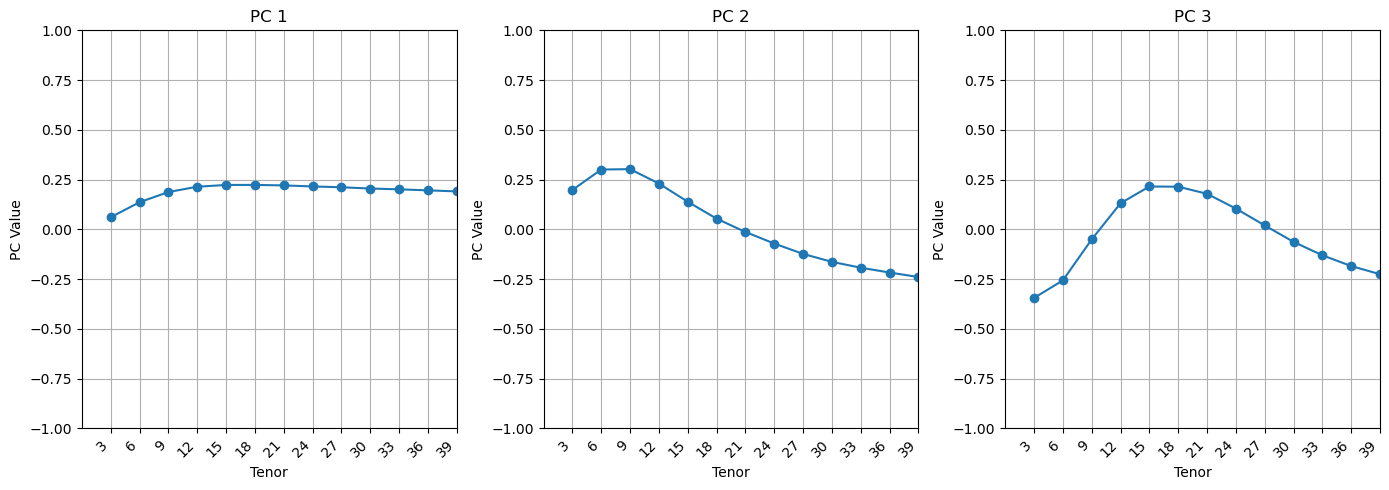

In [107]:
lambd, E = pca_port(portfolio, Q)
num_columns = E.shape[1]  
tenors = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39]

plt.figure(figsize=(14, 5))

for i in range(num_columns):
    plt.subplot(1, 3, i + 1)
    plt.plot(tenors, E[3:16, i], marker='o', linestyle='-')
    plt.title(f'PC {i + 1}')
    plt.xlabel('Tenor')
    plt.ylabel('PC Value')
    plt.xticks(
        ticks=tenors,
        labels=[f'{month}' for month in tenors],
        rotation=45,  
        ha='right'    
    )
    plt.xlim(0, 39)
    plt.ylim(-1, 1)
    plt.grid(True)

plt.tight_layout()
plt.show()